In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

We got equations: 
$$
\begin{cases}
\frac{dG}{dt} = p_1 G + p_2 X + p_3 \\
\frac{dX}{dt} = p_4 X + I(t)
\end{cases}
$$

Let's first generate G

In [3]:
def getI(t, I_max, a=1, t1=10):
    return I_max / np.cosh(a * (t - t1))

def find_g(p1, p2, p3, p4, p5, X0, I_max, T, step=1):
    '''
    Modelat G with given parameters
    '''
    g = [p5]
    x = [X0]
    
    for t in range(int(T * step)):
        dg_dt = p1 * g[-1] + p2 * x[-1] + p3
        dx_dt = getI(t / step, I_max) + p4 * x[-1]
        
        g.append(g[-1] + dg_dt / step)
        x.append(x[-1] + dx_dt / step)
        
    return np.array(g), np.array(x)

In [18]:
p1 = -6.5 / 100
p2 = -9.1 / 1000
p3 = 5.97
p4 = -1.01 / 10

p5 = 150
X0 = 80
I_max = 100

In [19]:
step = 100
T = 60
G, X = find_g(p1, p2, p3, p4, p5, X0, I_max, T, step)
I = [getI(t / step, I_max) for t in range(int(T * step) + 1)]

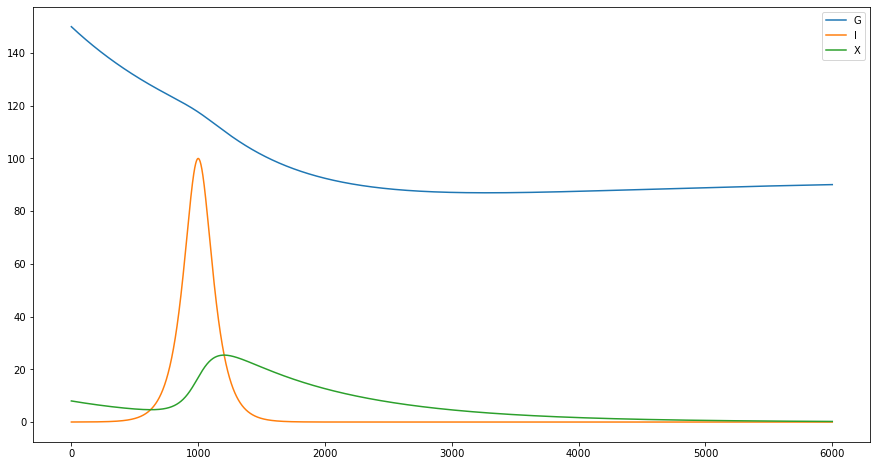

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(G, label='G')
plt.plot(I, label='I')
plt.plot(X/10, label='X')
plt.legend()

Let's prove numerically that this problem non-observable. To do so we'll find infinite number parameters for the same G that fit equations

In [35]:
def get_params_basic(p4, G, I, X0, step):
    '''
    For given G, I, p_4 and X(0) find p_1, p_2 and p_3 that fit equations and r2_score of that fit
    '''

    X_ = [X0]

    #find X from second equation
    for pos, g in enumerate(G[:-1]):
        dx_dt = I[pos] + p4 * X_[-1]
        X_.append(X_[-1] + dx_dt / step)

    #find p1, p2, p3 from first equation
    Y = (G[1:] - G[:-1]) * step
    Z = np.vstack([G[:-1], X_[:-1]]).T

    model = LinearRegression().fit(Z[:], Y[:])
    y_pred = model.predict(Z[:])
           
    return r2_score(y_pred, Y), model.coef_, model.intercept_

def get_params_pro(p4, G, I, X0, step):
    '''
    For given p4 and G trying to find X0 (close to one that user defined), so r2_score is best
    Print that r2_score and return p_1, p_2, p_3
    '''
    grid = np.arange(0.2, 10.001, 0.05)
    r2_scores = [get_params_basic(p4, G, I,  X0 * coef, step)[0] for coef in grid]
    best_coef = grid[np.argmax(r2_scores)]
    res = get_params_basic(p4, G, I, X0 * best_coef, step)
    print("R2 score of fit:", round(res[0], 4))
    
    return res[1:]

Now for different $p_4$ we'll find different $p_1, p_2, p_3$ that fit equations

In [36]:
res = []
for p4_ in np.arange(0.5, 2, 0.1) * p4:
    print("p_4={}".format(round(p4_, 4)),end=' ')
    [p1_, p2_], p3_ = get_params_pro(p4_, G[::step], I[::step], X0, 1)
    res.append([p1_, p2_, p3_, p4_])
res = np.array(res)

p_4=-0.0505 R2 score of fit: 0.9833
p_4=-0.0606 R2 score of fit: 0.9865
p_4=-0.0707 R2 score of fit: 0.9891
p_4=-0.0808 R2 score of fit: 0.991
p_4=-0.0909 R2 score of fit: 0.9924
p_4=-0.101 R2 score of fit: 0.9931
p_4=-0.1111 R2 score of fit: 0.9934
p_4=-0.1212 R2 score of fit: 0.9932
p_4=-0.1313 R2 score of fit: 0.9926
p_4=-0.1414 R2 score of fit: 0.9917
p_4=-0.1515 R2 score of fit: 0.9905
p_4=-0.1616 R2 score of fit: 0.9891
p_4=-0.1717 R2 score of fit: 0.9876
p_4=-0.1818 R2 score of fit: 0.9859
p_4=-0.1919 R2 score of fit: 0.9841


Here you can see how parameters change

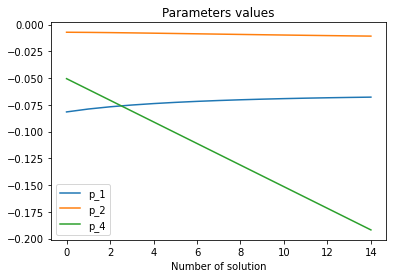

In [37]:
plt.xlabel('Number of solution')
plt.title('Parameters values')
plt.plot(res[:, 0], label='p_1')
plt.plot(res[:, 1], label='p_2')
plt.plot(res[:, 3], label='p_4')
plt.legend()

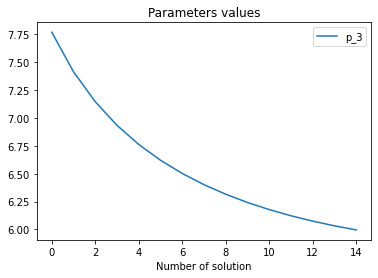

In [38]:
plt.xlabel('Number of solution')
plt.title('Parameters values')
plt.plot(res[:, 2], label='p_3')
plt.legend()

## So we can see that for one G there could be several $p_1, p_2, p_3, p_4$ that fit equations. So problem is non-observable